## A/B тестирование эффективности рекламной кампании

В рамках проекта проводится анализ результатов A/B-тестирования, целью которого является оценка эффективности новой рекламной кампании. 

Тестовая группа (ad) - большинство пользователей, которые видели коммерческую рекламу продукта.

Контрольная группа (psa) - меньшая часть пользователей, которые вместо рекламы видели баннер с социальной рекламой (Public Service Announcement - PSA). Баннер был того же размера и находился на том же месте.

Основная цель анализа - определить, была ли рекламная кампания успешной, и проверить, является ли разница в поведении пользователей между группами статистически значимой, а также ответить на вопросы:

- *Каков доверительный интервал для разницы в показателях конверсии, если она существует?*

- *Каков размер эффекта (насколько лучше/хуже показала себя группа коммерческой рекламы)?*

- *В какие дни недели и часы суток рекламная кампания показывает наибольшую эффективность? Есть ли статистически значимая разница в конверсии между разными временными слотами?*

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy.stats import norm, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep, proportion_effectsize
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower

from itertools import combinations

In [2]:
# Считываем данные из csv-файла
data = pd.read_csv('../data/marketing_AB.csv', index_col=0)
# Преобразуем названия столбцов
data.columns = [col.replace(' ', '_') for col in data.columns]
data.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [3]:
# Типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


### Описание столбцов:

user_id: Уникальный ID пользователя

test_group: Тестовая группа, к которой принадлежал пользователь:

- ad - видел рекламу (тестовая группа)

- psa - видел социальный баннер (контрольная группа)

converted: Факт конверсии. True, если пользователь купил продукт, и False в противном случае (это наша целевая метрика)

total_ads: Общее количество рекламных объявлений, увиденных пользователем

most_ads_day: День недели, в который пользователь видел наибольшее количество рекламы

most_ads_hour: Час дня, в который пользователь видел наибольшее количество рекламы

In [4]:
# Переименуем значения для удобства: ad -> test, psa -> control
data.loc[data['test_group'] == 'ad', 'test_group'] = 'test'
data.loc[data['test_group'] == 'psa', 'test_group'] = 'control'

## 1. Исследование данных

In [5]:
print('Кол-во уникальных пользователей: {}'.format(data['user_id'].nunique()))
print('Всего {} группы пользователей: {}'.format(len(data['test_group'].unique()), data['test_group'].unique()))
print('Уникальные значения в столбце {}: {}'.format('most_ads_day', data['most_ads_day'].unique()))
print('Уникальные значения в столбце {}: {}'.format('most_ads_hour', np.sort(data['most_ads_hour'].unique())))
print('Пропущенные значения:')
print(data.isna().sum())

Кол-во уникальных пользователей: 588101
Всего 2 группы пользователей: ['test' 'control']
Уникальные значения в столбце most_ads_day: ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
Уникальные значения в столбце most_ads_hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Пропущенные значения:
user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64


Количество пользователей в каждой группе:
test_group
test       564577
control     23524
Name: count, dtype: int64


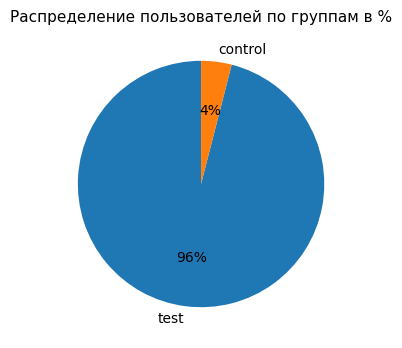

In [6]:
# Количество пользователей в каждой группе
group_sizes = data['test_group'].value_counts()
print('Количество пользователей в каждой группе:')
print(group_sizes)

# Визуализация с помощью круговой диаграммы
plt.figure(figsize=(4, 4))  
plt.pie(
    group_sizes,  
    labels=group_sizes.index,  
    autopct='%1.0f%%',  # Формат для отображения процентов внутри секторов
    startangle=90 
)

plt.title('Распределение пользователей по группам в %', fontsize=11)
plt.show()

In [7]:
# Проверим пересечение пользователей между группами
# Считаем, в скольких группах состоит каждый пользователь
user_intersection = data.groupby('user_id')['test_group'].nunique()

# Смотрим на пользователей, которые попали более чем в одну группу
print('Количество пользователей, попавших более чем в одну группу: {}'.format(user_intersection[user_intersection > 1].count()))

Количество пользователей, попавших более чем в одну группу: 0


## 2. Анализ на наличие выбросов

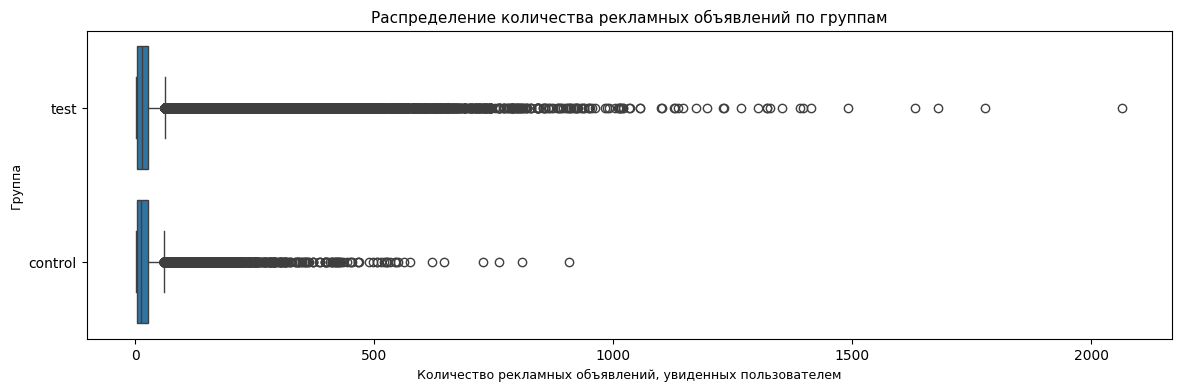

Медианное количество объявлений в группах:


test_group
control    12.0
test       13.0
Name: total_ads, dtype: float64

In [8]:
plt.figure(figsize=(14,4))
sns.boxplot(data=data, x='total_ads', y='test_group')
plt.title('Распределение количества рекламных объявлений по группам', fontsize=11)
plt.xlabel('Количество рекламных объявлений, увиденных пользователем', fontsize=9)
plt.ylabel('Группа', fontsize=9)
plt.show()

print('Медианное количество объявлений в группах:')
data.groupby('test_group')['total_ads'].median()

In [9]:
# Пройдемся по каждой группе и посчитаем выбросы отдельно
for group in data['test_group'].unique():
    group_data = data[data['test_group'] == group]
    
    # Считаем квантили и IQR 
    Q1 = group_data['total_ads'].quantile(0.25)
    Q3 = group_data['total_ads'].quantile(0.75)
    IQR = Q3 - Q1

    down_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Находим выбросы для этой группы
    outliers = group_data[(group_data['total_ads'] < down_limit) | (group_data['total_ads'] > upper_limit)]
    
    print(f"--- Анализ для группы '{group}' ---")
    print(f'Границы выбросов: Нижняя = {down_limit:.2f}, Верхняя = {upper_limit:.2f}')
    print(f'Всего значений в группе: {len(group_data)}')
    print(f'Количество выбросов: {len(outliers)}')
    print(f'Процент выбросов: {((len(outliers) / len(group_data)) * 100):.2f}%')
    print() # Пустая строка для разделения

# Найдем выбросы для всего набора данных
# Считаем квантили и IQR 
Q1 = data['total_ads'].quantile(0.25)
Q3 = data['total_ads'].quantile(0.75)
IQR = Q3 - Q1

down_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Находим выбросы для этой группы
outliers = data[(data['total_ads'] < down_limit) | (data['total_ads'] > upper_limit)]
    
print(f'--- Анализ для всего набора данных ---')
print(f'Границы выбросов: Нижняя = {down_limit:.2f}, Верхняя = {upper_limit:.2f}')
print(f'Всего значений в: {len(data)}')
print(f'Количество выбросов: {len(outliers)}')
print(f'Процент выбросов: {((len(outliers) / len(data)) * 100):.2f}%')

--- Анализ для группы 'test' ---
Границы выбросов: Нижняя = -30.50, Верхняя = 61.50
Всего значений в группе: 564577
Количество выбросов: 49861
Процент выбросов: 8.83%

--- Анализ для группы 'control' ---
Границы выбросов: Нижняя = -29.00, Верхняя = 59.00
Всего значений в группе: 23524
Количество выбросов: 2321
Процент выбросов: 9.87%

--- Анализ для всего набора данных ---
Границы выбросов: Нижняя = -30.50, Верхняя = 61.50
Всего значений в: 588101
Количество выбросов: 52057
Процент выбросов: 8.85%


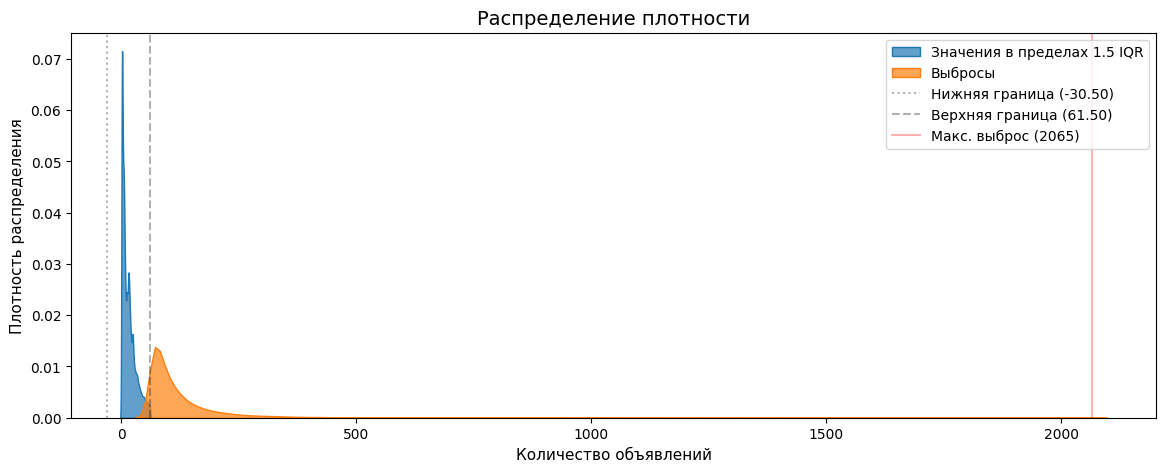

In [10]:
fig, ax = plt.subplots(figsize=(14, 5)) 

# Создаем маску для 'невыбросов'
non_outliers_mask = ~data.index.isin(outliers.index)
non_outliers_data = data[non_outliers_mask]

sns.kdeplot(data=non_outliers_data['total_ads'], 
            label='Значения в пределах 1.5 IQR', 
            fill=True, 
            alpha=0.7
            )
sns.kdeplot(data=outliers['total_ads'], 
            label='Выбросы', 
            fill=True, 
            alpha=0.7
            )

# Добавляем вертикальные линии на ось `ax` для верхней и нижней границ
ax.axvline(x=down_limit, color='black', linestyle=':', alpha=0.3, label=f'Нижняя граница ({down_limit:.2f})')
ax.axvline(x=upper_limit, color='black', linestyle='--', alpha=0.3, label=f'Верхняя граница ({upper_limit:.2f})')
ax.axvline(x=outliers['total_ads'].max(), color='red', linestyle='-', alpha=0.3, label=f"Макс. выброс ({outliers['total_ads'].max()})")

ax.set_title('Распределение плотности', fontsize=14)
ax.set_xlabel('Количество объявлений', fontsize=11)
ax.set_ylabel('Плотность распределения', fontsize=11)
ax.legend(loc='upper right')

plt.show()

In [11]:
# Посмотрим, есть ли конверсия от пользователей, у которых экстремальные значения в total_ads
outliers.groupby('test_group')['converted'].value_counts(normalize=True).round(4)*100

test_group  converted
control     False        91.17
            True          8.83
test        False        84.89
            True         15.11
Name: proportion, dtype: float64

## 3. Анализ влияния выбросов на ключевые метрики

In [12]:
print('--- Сравнение конверсии по группам ---')
print('\nНа полных данных:')
print(data.groupby('test_group')['converted'].mean().round(4) * 100)

print('\nНа данных без выбросов:')
print(non_outliers_data.groupby('test_group')['converted'].mean().round(4) * 100)

print('\n--- Сравнение среднего кол-ва просмотренных объявлений по группам ---')
print('\nНа полных данных:')
print(data.groupby('test_group')['total_ads'].mean().round(2))

print('\nНа данных без выбросов:')
print(non_outliers_data.groupby('test_group')['total_ads'].mean().round(2))

--- Сравнение конверсии по группам ---

На полных данных:
test_group
control    1.79
test       2.55
Name: converted, dtype: float64

На данных без выбросов:
test_group
control    1.06
test       1.34
Name: converted, dtype: float64

--- Сравнение среднего кол-ва просмотренных объявлений по группам ---

На полных данных:
test_group
control    24.76
test       24.82
Name: total_ads, dtype: float64

На данных без выбросов:
test_group
control    14.51
test       15.16
Name: total_ads, dtype: float64


На 'грязных' данных конверсия в тестовой группе (2.55%) значительно выше, чем в контрольной (1.79%). Однако после удаления выбросов конверсии в обеих группах снизились: в тестовой группе до 1.34%, а в контрольной до 1.06%. Это говорит о том, что первоначальная оценка эффекта от рекламы была сильно завышена из-за 'шума' в данных.

Удаление выбросов привело к ожидаемому снижению и среднего количества просмотров почти вдвое, что подтверждает их аномальный характер.

Таким образом, в ходе анализа были обнаружены пользователи с аномально высоким количеством просмотров рекламы. Несмотря на наличие конверсий в этой группе (15,11%  в тестовой и 8,83% в контрольной), их поведенческий паттерн (вероятно, связанный с длительно открытыми вкладками) признан нерепрезентативным для целевой аудитории. Для обеспечения достоверности результатов A/B теста, эти пользователи будут исключены из дальнейшего анализа.

## 4. Эффективность рекламной кампании

**Существует ли статистически значимая разница в показателях конверсии между группами?**

Формулировка гипотезы:

Нулевая гипотеза (H0): Нет никакой разницы в конверсии между группами (conv_test = conv_control)

Альтернативная гипотеза (H1): Существует статистически значимая разница в конверсии между группами (conv_test ≠ conv_control)

Уровень значимости составляет 5%

- У нас есть две независимые группы (test и control) и пользователи в них не пересекаются.
- В обеих группах десятки тысяч пользователей. 
- Целевая метрика converted является бинарной, она может принимать только два значения (True - 1, False - 0)

Следовательно, для выявления статистической разницы между группами мы будем использовать Z-тест для пропорций

In [13]:
# Уже была посчитана конверсия для обеих групп без выбросов
conversion_rate = (non_outliers_data.groupby('test_group')['converted'].mean() * 100).reset_index()
print(conversion_rate)

# Разница
control_conv = conversion_rate.values[0, 1]
test_conv = conversion_rate.values[1, 1]

abs_diff = test_conv - control_conv
rel_diff = (test_conv - control_conv) / control_conv

print(f'\nКонверсия в тестовой группе ({test_conv:.2f}%) выше, чем в контрольной ({control_conv:.2f}%).')
print(f'Абсолютный прирост конверсии составил {abs_diff:.2f} процентных пунктов.')
print(f'Относительный прирост конверсии составил {rel_diff:.2%}.') 

  test_group  converted
0    control   1.059640
1       test   1.338408

Конверсия в тестовой группе (1.34%) выше, чем в контрольной (1.06%).
Абсолютный прирост конверсии составил 0.28 процентных пунктов.
Относительный прирост конверсии составил 26.31%.


### **Z-тест для пропорций**

In [14]:
# Группируем данные для получения количества конверсий и общего числа наблюдений
conversion_counts = non_outliers_data.groupby('test_group')['converted'].sum()
total_counts = non_outliers_data.groupby('test_group')['converted'].count()

# Разделяем данные для теста и контроля
count = np.array([conversion_counts['test'], conversion_counts['control']])
nobs = np.array([total_counts['test'], total_counts['control']])

# Проводим Z-тест
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f'Z-статистика: {z_stat:.4f}')
print(f'P-value: {p_value:.4f}')

# Интерпретируем результат
alpha = 0.05  # Уровень значимости

if p_value < alpha:
    print(f'\nОтвергаем нулевую гипотезу (p-value < {alpha})')
    print('Разница в конверсии между группами является статистически значимой')
else:
    print(f'\nНе удалось отвергнуть нулевую гипотезу (p-value >= {alpha})')
    print('Статистически значимой разницы в конверсии между группами не обнаружено')

Z-статистика: 3.4859
P-value: 0.0005

Отвергаем нулевую гипотезу (p-value < 0.05)
Разница в конверсии между группами является статистически значимой


**Каков доверительный интервал для разницы в показателях конверсии?**

In [15]:
ci = confint_proportions_2indep(
    count1=conversion_counts['test'], 
    nobs1=total_counts['test'],        
    count2=conversion_counts['control'],  
    nobs2=total_counts['control'],        
    alpha=0.05            
)

print(f'95% доверительный интервал для разницы конверсий: [{ci[0]:.4f}, {ci[1]:.4f}]')
print(f'В процентах: [{ci[0]:.2%}, {ci[1]:.2%}]')

95% доверительный интервал для разницы конверсий: [0.0013, 0.0041]
В процентах: [0.13%, 0.41%]


Нижняя граница интервала больше нуля. 
Это значит, что мы на 95% уверены, что конверсия в тестовой группе действительно выше, чем в контрольной.

**Каков размер эффекта?**

In [16]:
p_control = non_outliers_data[non_outliers_data['test_group'] == 'control']['converted'].mean()
p_test = non_outliers_data[non_outliers_data['test_group'] == 'test']['converted'].mean()
n_control = len(non_outliers_data[non_outliers_data['test_group'] == 'control'])
n_test = len(non_outliers_data[non_outliers_data['test_group'] == 'test'])

# Расчет размера эффекта по Коэну (Cohen's h) 
effect_size = proportion_effectsize(prop1=p_test, prop2=p_control)
print(f"Размер эффекта (Cohen's h): {effect_size:.4f}")

# Расчет статистической мощности 
# nobs1 - это количество наблюдений в одной группе, мы предполагаем их равными для расчета
analysis = TTestIndPower()
power = analysis.solve_power(
    effect_size=effect_size,     # Размер эффекта
    nobs1=n_test,                # Количество наблюдений в тестовой группе
    alpha=0.05,                  
    ratio=n_control/n_test,      # Отношение размеров выборок
    alternative='two-sided'
)
print(f'\nСтатистическая мощность теста: {power:.2%}')

Размер эффекта (Cohen's h): 0.0257

Статистическая мощность теста: 95.65%


Значение размера эффекта попадает в категорию 'очень маленький' эффект (поскольку 0.0257 < 0.2).
Несмотря на то, что разница в конверсии статистически значима, ее практическая величина очень мала.

Статистическая мощность теста гораздо выше стандартного порога в 80%.

## 5. Влияние дня недели и часа дня показа на конверсию

В данном разделе будем рассматривать тестовую группу, так как рекламные объявления показывались только в ней.

In [17]:
test_group = non_outliers_data[non_outliers_data['test_group'] == 'test'].copy()
test_group.head(3)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
2,1144181,test,False,21,Tuesday,18
7,1496843,test,False,17,Sunday,18
8,1448851,test,False,21,Tuesday,19


In [18]:
# Список с правильным порядком дней недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_dtype = CategoricalDtype(categories=days_order, ordered=True)
# Применяем категориальный тип к столбцу с днями недели
test_group['most_ads_day'] = test_group['most_ads_day'].astype(day_dtype)

### Количество рекламных объявлений по дням недели

  most_ads_day  total_ads
0       Monday    1124908
1      Tuesday    1037793
2    Wednesday    1033345
3     Thursday    1056620
4       Friday    1223041
5     Saturday    1146880
6       Sunday    1180404


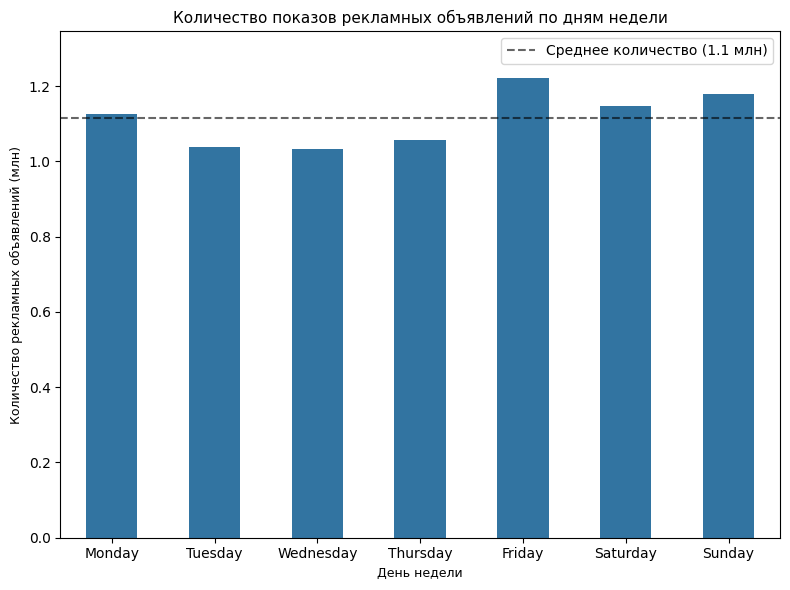

In [19]:
daily_total_ads = test_group.groupby('most_ads_day', observed=True)['total_ads'].sum().reset_index()
print(daily_total_ads)

# Преобразуем значения в миллионы
daily_total_ads['total_ads_mln'] = daily_total_ads['total_ads'] / 1_000_000

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=daily_total_ads, 
    x='most_ads_day', 
    y='total_ads_mln',
    width=0.5
)

mean_total_ads_mln = daily_total_ads['total_ads_mln'].mean()

ax.axhline(
    y=mean_total_ads_mln, 
    color='black', 
    linestyle='--',  
    alpha=0.6,       
    label=f'Среднее количество ({mean_total_ads_mln:.1f} млн)'
)

ax.set_title('Количество показов рекламных объявлений по дням недели', fontsize=11)
ax.set_xlabel('День недели', fontsize=9)
ax.set_ylabel('Количество рекламных объявлений (млн)', fontsize=9)

ax.set_ylim(0, daily_total_ads['total_ads_mln'].max() * 1.1)
ax.legend()

plt.tight_layout()
plt.show()

На графике виден явный пик в пятницу, где количество показов достигает примерно 1.22 млн, что заметно выше среднего (1.1 млн).

### Коэффициент конверсии по дням недели

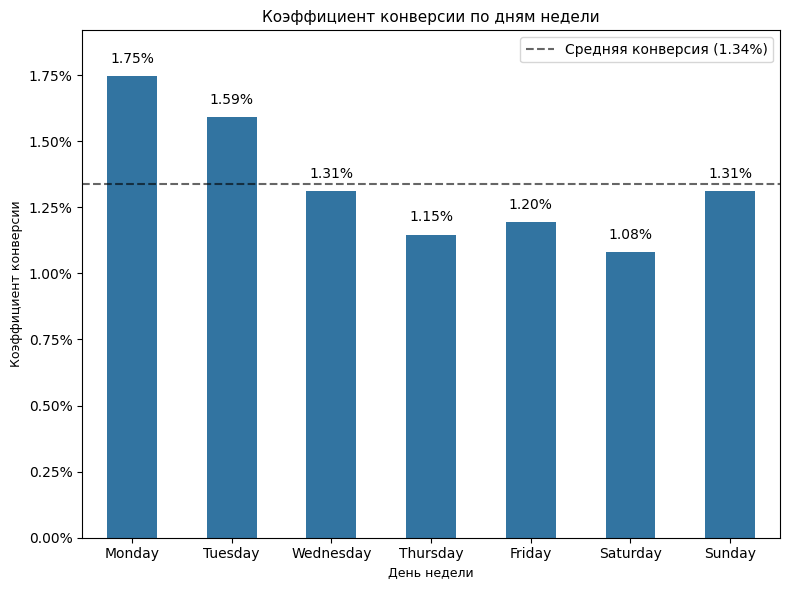

In [20]:
daily_conversion = test_group.groupby('most_ads_day', observed=True)['converted'].mean().round(5).reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=daily_conversion, 
    x='most_ads_day', 
    y='converted',
    width=0.5
)

# Средняя конверсия по всем дням
mean_conversion = daily_conversion['converted'].mean()

ax.axhline(
    y=mean_conversion, 
    color='black', 
    linestyle='--',  
    alpha=0.6,       
    label=f'Средняя конверсия ({mean_conversion:.2%})' # Добавляем в легенду
)

# Добавляем подписи со значениями конверсии над столбцами
for index, row in daily_conversion.iterrows():
    ax.text(index, row.converted + 0.0005, f'{row.converted:.2%}', color='black', ha='center', fontsize=10)

# Настраиваем заголовки и подписи осей
ax.set_title('Коэффициент конверсии по дням недели', fontsize=11)
ax.set_xlabel('День недели', fontsize=9)
ax.set_ylabel('Коэффициент конверсии', fontsize=9)

# Форматируем ось Y, чтобы она отображалась в процентах
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Устанавливаем лимит для оси Y для лучшей наглядности
ax.set_ylim(0, daily_conversion['converted'].max() * 1.1)
ax.legend()

plt.tight_layout() 
plt.show()

- В пятницу на графике выше ('Количество рекламных объявлений по дням недели') мы видели максимальное количество показов рекламы, но при этом конверсия в этот день ниже среднего значения. Мы тратим больше всего 'усилий' (показов) в день, который приносит относительно слабую отдачу. Это явный признак неэффективного распределения бюджета.

- В понедельник мы видим самую высокую конверсию, но при этом количество показов находится лишь на уровне среднего. Мы могли бы получить еще больше конверсий, если бы увеличили объем показов в этот день.

- В субботу и воскресенье мы видим довольно высокий объем показов. При этом суббота - день с самой низкой конверсией.
Рекламная активность в выходные может быть неоптимальной. Особенно много ресурсов тратится впустую в субботу.

- Конверсия в понедельник и вторник заметно выше среднего значения. 
Разница между понедельником (1.75%) и субботой (1.08%) выглядит довольно существенной, что дает основания предполагать, что эта разница статистически значима. Проверим данное предположение с помощью Хи-квадрат теста.

In [21]:
# Создание таблицы сопряженности 
contingency_table = pd.crosstab(
    test_group['most_ads_day'],  # Строки - это дни недели
    test_group['converted']      # Столбцы - это 'True' (конверсия) и 'False'
)

print('Таблица сопряженности:')
print(contingency_table)

# Проведение Хи-квадрат теста 
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'\nСтатистика Хи-квадрат: {chi2:.4f}')
print(f'P-value: {p_value:.4f}')
print(f'Степени свободы (dof): {dof}')

alpha = 0.05  

if p_value < alpha:
    print(f'\nОтвергаем нулевую гипотезу (p-value < {alpha})')
    print('Существует статистически значимая разница в конверсии между днями недели')
else:
    print(f'Не удалось отвергнуть нулевую гипотезу (p-value >= {alpha})')
    print('Статистически значимой разницы в конверсии между днями недели не обнаружено')

Таблица сопряженности:
converted     False  True 
most_ads_day              
Monday        74553   1324
Tuesday       67108   1084
Wednesday     69524    924
Thursday      71981    835
Friday        79215    958
Saturday      71151    777
Sunday        74295    987

Статистика Хи-квадрат: 197.4258
P-value: 0.0000
Степени свободы (dof): 6

Отвергаем нулевую гипотезу (p-value < 0.05)
Существует статистически значимая разница в конверсии между днями недели


In [22]:
days = contingency_table.index.tolist()
results = []

# Проводим попарные Z-тесты для всех комбинаций дней 
for day1, day2 in combinations(days, 2):
    # Данные для двух дней
    count = contingency_table.loc[[day1, day2]][True].values
    nobs = contingency_table.loc[[day1, day2]].sum(axis=1).values
    
    # Z-тест
    stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    results.append({'Day 1': day1, 'Day 2': day2, 'P-value': p_value})

# Создаем DataFrame с результатами
p_values_df = pd.DataFrame(results)

# Применяем поправку на множественные сравнения (метод Холма) 
reject, p_values_corrected, _, _ = multipletests(
    p_values_df['P-value'], 
    alpha=0.05, 
    method='holm'
)

# Добавляем скорректированные p-value и результат в наш DataFrame
p_values_df['P-value Corrected (Holm)'] = p_values_corrected
p_values_df['Significant'] = reject

print('Итоговые результаты с поправкой Холма-Бонферрони')
print(p_values_df.sort_values(by='P-value Corrected (Holm)'))

Итоговые результаты с поправкой Холма-Бонферрони
        Day 1      Day 2       P-value  P-value Corrected (Holm)  Significant
4      Monday   Saturday  3.845592e-27              8.075744e-26         True
2      Monday   Thursday  5.430535e-22              1.086107e-20         True
3      Monday     Friday  1.475446e-19              2.803347e-18         True
9     Tuesday   Saturday  8.425311e-17              1.516556e-15         True
7     Tuesday   Thursday  7.314025e-13              1.243384e-11         True
5      Monday     Sunday  6.252898e-12              1.000464e-10         True
1      Monday  Wednesday  1.651951e-11              2.477926e-10         True
8     Tuesday     Friday  7.849629e-11              1.098948e-09         True
10    Tuesday     Sunday  9.975506e-06              1.296816e-04         True
6     Tuesday  Wednesday  1.478922e-05              1.774706e-04         True
20   Saturday     Sunday  4.730027e-05              5.203030e-04         True
13  Wednesday  

На основе этих данных мы можем сгруппировать дни недели по их эффективности:

- **'Высокая эффективность':** понедельник и вторник - разница между ними статистически незначима, поэтому их можно считать одинаково хорошими днями. Они оба значимо лучше всех остальных дней.
- **'Средняя эффективность':** среда и воскресенье - конверсия в эти дни практически одинакова. Они значимо хуже, чем понедельник и вторник, но при этом значимо лучше, чем суббота.

- **'Низкая эффективность':** четверг, пятница и суббота - показывают самые низкие результаты, их можно объединить в группу дней, требующих особого внимания или оптимизации.

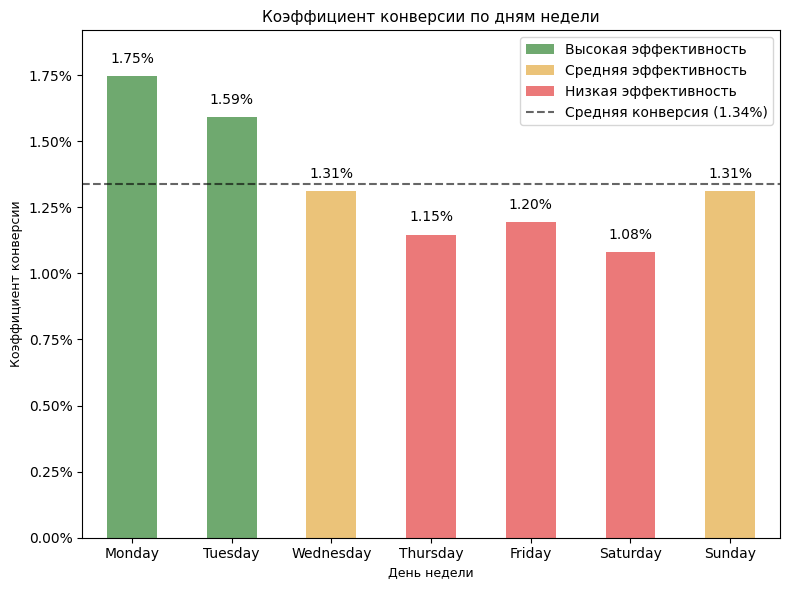

In [23]:
# Нарисуем график распределения по дням недели, раскрасив столбцы в соответствии с принадлежностью дня к кластеру
plt.figure(figsize=(8, 6))

# Словарь для сопоставления дней и кластеров эффективности
cluster_map = {
    'Monday': 'Высокая эффективность',
    'Tuesday': 'Высокая эффективность',
    'Wednesday': 'Средняя эффективность',
    'Sunday': 'Средняя эффективность',
    'Thursday': 'Низкая эффективность',
    'Friday': 'Низкая эффективность',
    'Saturday': 'Низкая эффективность'
}

# Добавляем столбец с кластерами
daily_conversion['efficiency_cluster'] = daily_conversion['most_ads_day'].map(cluster_map)

ax = sns.barplot(
    data=daily_conversion, 
    x='most_ads_day', 
    y='converted',
    width=0.5,
    hue='efficiency_cluster', 
    palette=['green', 'orange', 'red']
)

ax.axhline(
    y=mean_conversion, 
    color='black', 
    linestyle='--',  
    alpha=0.6,       
    label=f'Средняя конверсия ({mean_conversion:.2%})' # Добавляем в легенду
)

# Сделаем цвета прозрачными
for patch in ax.patches:
    patch.set_alpha(0.6)  
    
# Добавляем подписи со значениями конверсии над столбцами
for index, row in daily_conversion.iterrows():
    ax.text(index, row.converted + 0.0005, f'{row.converted:.2%}', color='black', ha='center', fontsize=10)

# Настраиваем заголовки и подписи осей
ax.set_title('Коэффициент конверсии по дням недели', fontsize=11)
ax.set_xlabel('День недели', fontsize=9)
ax.set_ylabel('Коэффициент конверсии', fontsize=9)

# Форматируем ось Y, чтобы она отображалась в процентах
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Устанавливаем лимит для оси Y для лучшей наглядности
ax.set_ylim(0, daily_conversion['converted'].max()*1.1)
ax.legend()

plt.tight_layout() 
plt.show()

### Количество пользователей по часам

    most_ads_hour  total_ads
0               0       4869
1               1       4172
2               2       4748
3               3       2396
4               4        599
5               5        599
6               6       1594
7               7       5384
8               8      15573
9               9      27435
10             10      34226
11             11      40273
12             12      41077
13             13      41247
14             14      40010
15             15      39077
16             16      33244
17             17      30733
18             18      28206
19             19      26468
20             20      25062
21             21      26061
22             22      23388
23             23      18275


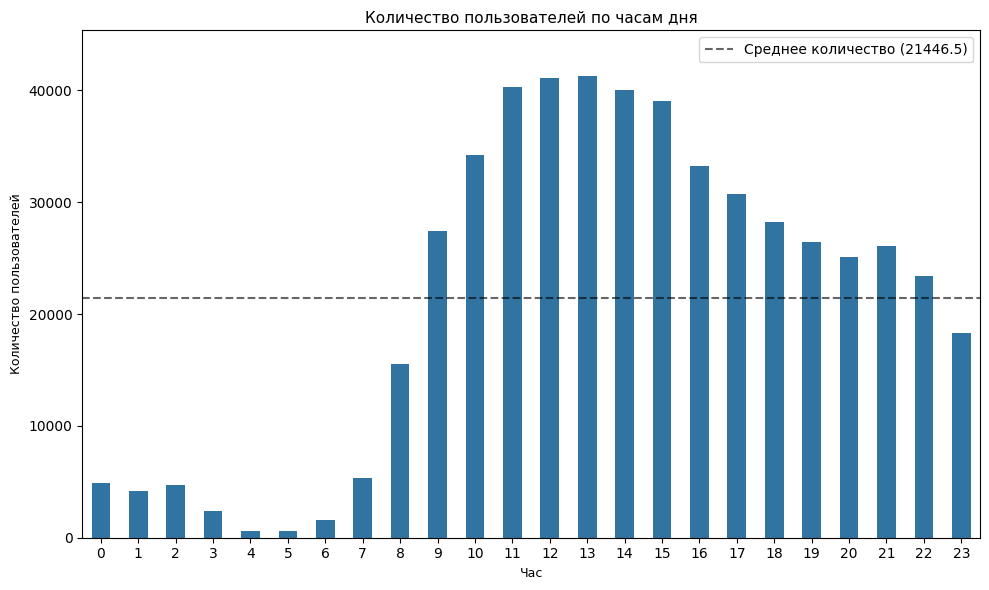

In [24]:
hour_total_ads = test_group.groupby('most_ads_hour', observed=True)['total_ads'].count().reset_index()
print(hour_total_ads)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=hour_total_ads, 
    x='most_ads_hour', 
    y='total_ads',
    width=0.5
)

mean_total_ads = hour_total_ads['total_ads'].mean()

ax.axhline(
    y=mean_total_ads, 
    color='black', 
    linestyle='--',  
    alpha=0.6,       
    label=f'Среднее количество ({mean_total_ads:.1f})'
)

ax.set_title('Количество пользователей по часам дня', fontsize=11)
ax.set_xlabel('Час', fontsize=9)
ax.set_ylabel('Количество пользователей', fontsize=9)

ax.set_ylim(0, hour_total_ads['total_ads'].max() * 1.1)
ax.legend()

plt.tight_layout()
plt.show()

- В ранние часы с 0 до 7 утра активность минимальна.

- Активность начинает резко расти с 8-9 утра и достигает своего пика в период с 11 до 14 часов, когда более 40 000 пользователей в час просматривают рекламу.

- После 15 часов активность постепенно снижается, но остается на достаточно высоком уровне до позднего вечера (до 22 часов).

### Коэффициент конверсии по часам

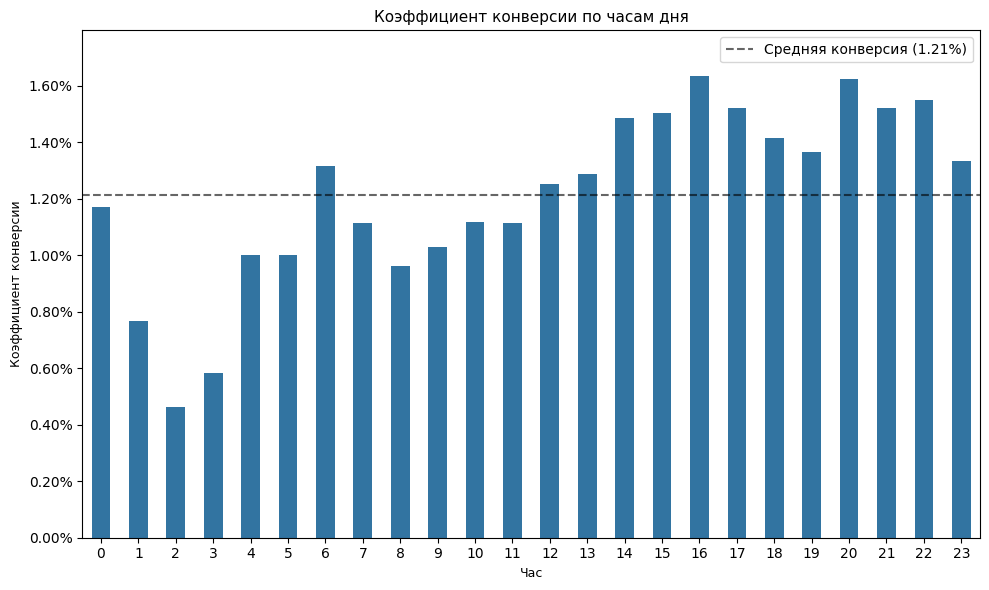

Максимальные значения коэффициента конверсии приходятся на часы:
    most_ads_hour  converted
16             16    0.01633
20             20    0.01624
22             22    0.01548
21             21    0.01523
17             17    0.01520


In [25]:
hour_conversion = test_group.groupby('most_ads_hour', observed=True)['converted'].mean().round(5).reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=hour_conversion, 
    x='most_ads_hour', 
    y='converted',
    width=0.5
)

# Средняя конверсия по всем дням
mean_conversion = hour_conversion['converted'].mean()

ax.axhline(
    y=mean_conversion, 
    color='black', 
    linestyle='--',  
    alpha=0.6,       
    label=f'Средняя конверсия ({mean_conversion:.2%})' # Добавляем в легенду
)

# Добавляем подписи со значениями конверсии над столбцами
#for index, row in hour_conversion.iterrows():
#    ax.text(index, row.converted + 0.0005, f'{row.converted:.2%}', color='black', ha='center', fontsize=10)

# Настраиваем заголовки и подписи осей
ax.set_title('Коэффициент конверсии по часам дня', fontsize=11)
ax.set_xlabel('Час', fontsize=9)
ax.set_ylabel('Коэффициент конверсии', fontsize=9)

# Форматируем ось Y, чтобы она отображалась в процентах
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Устанавливаем лимит для оси Y для лучшей наглядности
ax.set_ylim(0, hour_conversion['converted'].max() * 1.1)
ax.legend()

plt.tight_layout() 
plt.show()

print('Максимальные значения коэффициента конверсии приходятся на часы:')
print(hour_conversion.sort_values('converted', ascending=False).head(5))

- Самый главный вывод заключается в том, что пик конверсии не совпадает с пиком количества пользователей.

- Наиболее высокие показатели конверсии наблюдаются в вечерние часы, примерно с 15 до 22 часов. Особенно выделяются часы в районе 16-17 и 20-22, где конверсия значительно превышает средний уровень (1.21%).

- В период пиковой посещаемости (11-14 часов) конверсия находится на уровне среднего или даже ниже. Утренние часы (7-10) также показывают относительно низкую эффективность.

Визуальный анализ демонстрирует существенные колебания коэффициента конверсии в течение суток. Чтобы подтвердить, что эти различия реальны и не являются результатом случайности, необходимо провести статистическую проверку значимости разницы в конверсии между часами. Для этого мы воспользуемся Хи-квадрат тестом, который позволит нам проверить нулевую гипотезу о том, что конверсия одинакова во все часы суток.


In [26]:
# Создаем таблицу, где строки - это часы, а столбцы - количество конверсий и неконверсий
hourly_contingency_table = pd.crosstab(
    test_group['most_ads_hour'], 
    test_group['converted']      
)

# Проведение Хи-квадрат теста
chi2, p_value, dof, expected = chi2_contingency(hourly_contingency_table)

print('\nРезультаты Хи-квадрат теста для часов')
print(f'Статистика Хи-квадрат: {chi2:.4f}')
print(f'P-value: {p_value:.4f}')
print(f'Степени свободы (dof): {dof}')

# Интерпретация результата
alpha = 0.05  

if p_value < alpha:
    print(f'\nОтвергаем нулевую гипотезу (p-value < {alpha})')
    print('Существует статистически значимая разница в конверсии между разными часами дня')
else:
    print(f'Не удалось отвергнуть нулевую гипотезу (p-value >= {alpha})')
    print('Статистически значимой разницы в конверсии между разными часами дня не обнаружено')


Результаты Хи-квадрат теста для часов
Статистика Хи-квадрат: 195.3451
P-value: 0.0000
Степени свободы (dof): 23

Отвергаем нулевую гипотезу (p-value < 0.05)
Существует статистически значимая разница в конверсии между разными часами дня


Хи-квадрат тест подтвердил наличие статистически значимой разницы в конверсии по часам. Как видно на графике выше, наивысшая эффективность наблюдается в вечерние часы (16-17 и 20-22), в то время как дневные часы пиковой посещаемости показывают среднюю или низкую конверсию. Рекомендуется перераспределить рекламные усилия в пользу вечерних часов.

C:\Users\bagau\AppData\Local\Temp\ipykernel_17252\814323705.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


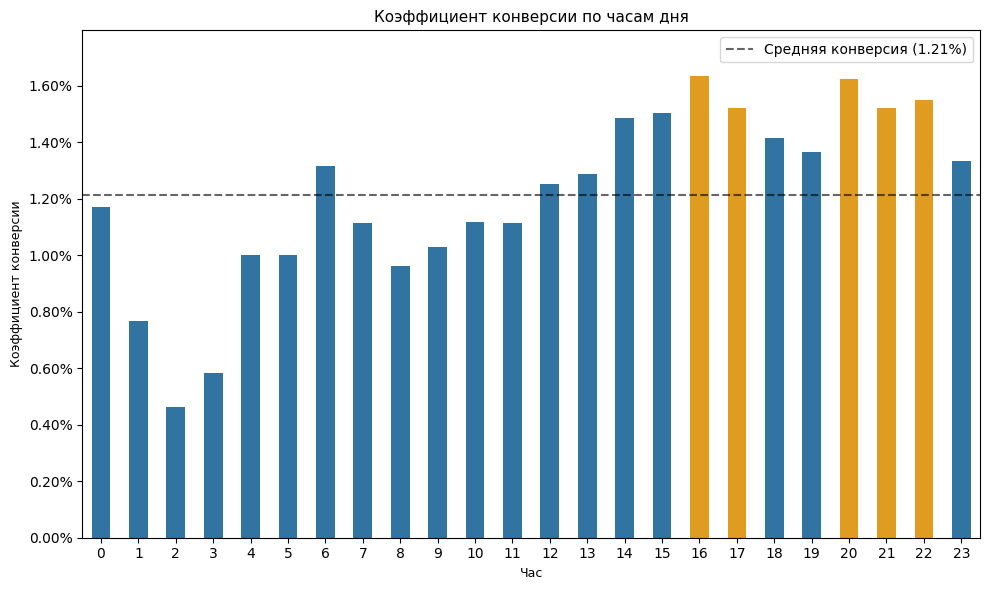

In [27]:
# График с цветовым обозначением наиболее эффективных часов
# Определяем стандартный цвет и цвет для выделения
default_color = sns.color_palette()[0] 
highlight_color = 'orange' 

# Список часов, которые нужно выделить
highlight_hours = [16, 17, 20, 21, 22]

# Создаем список цветов для каждого столбца
custom_palette = [highlight_color if hour in highlight_hours else default_color 
                  for hour in hour_conversion['most_ads_hour']]

hour_conversion = test_group.groupby('most_ads_hour', observed=True)['converted'].mean().round(5).reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=hour_conversion, 
    x='most_ads_hour', 
    y='converted',
    width=0.5,
    palette=custom_palette
)

# Средняя конверсия по всем дням
mean_conversion = hour_conversion['converted'].mean()

ax.axhline(
    y=mean_conversion, 
    color='black', 
    linestyle='--',  
    alpha=0.6,       
    label=f'Средняя конверсия ({mean_conversion:.2%})' # Добавляем в легенду
)

# Добавляем подписи со значениями конверсии над столбцами
#for index, row in hour_conversion.iterrows():
#    ax.text(index, row.converted + 0.0005, f'{row.converted:.2%}', color='black', ha='center', fontsize=10)

# Настраиваем заголовки и подписи осей
ax.set_title('Коэффициент конверсии по часам дня', fontsize=11)
ax.set_xlabel('Час', fontsize=9)
ax.set_ylabel('Коэффициент конверсии', fontsize=9)

# Форматируем ось Y, чтобы она отображалась в процентах
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Устанавливаем лимит для оси Y для лучшей наглядности
ax.set_ylim(0, hour_conversion['converted'].max() * 1.1)
ax.legend()

plt.tight_layout() 
plt.show()

## Выводы

Основная цель данного исследования заключалась в оценке эффективности рекламной кампании через A/B-тестирование. Был проведен анализ данных, очистка от выбросов и статистическая проверка гипотез. На основе полученных результатов можно сделать следующие выводы:

1. Была ли рекламная кампания успешной? 

Анализ показал, что тестовая группа, которой демонстрировалась коммерческая реклама, имеет статистически значимо более высокую конверсию, чем контрольная группа, видевшая социальную рекламу.

Коэффициент конверсии (на очищенных данных):

Тестовая группа: 1.34%

Контрольная группа: 1.06%

Статистическое подтверждение: Z-тест отверг нулевую гипотезу о равенстве конверсий с очень высоким уровнем значимости (p-value < 0.05).

2. Каков доверительный интервал и размер эффекта?

95% доверительный интервал для разницы в конверсии между тестовой и контрольной группами составил [0.13%, 0.41%]. Так как весь интервал находится выше нуля, мы можем с высокой уверенностью утверждать, что эффект от рекламы реален и положителен.

Абсолютный прирост конверсии составил 0.28 процентных пункта. Относительный прирост - около 26%. При этом стандартизированный размер эффекта по Коэну (h = 0.0257) классифицируется как небольшой, это означает, что хотя реклама и работает, ее реальное влияние на поведение пользователей невелико.

3. В какие дни и часы кампания наиболее эффективна?

Анализ временных паттернов показал, что эффективность рекламы сильно зависит от времени ее показа.

Понедельник и вторник показывают статистически значимо более высокую конверсию по сравнению с остальной неделей.

Также наблюдается четкий суточный паттерн: пик пользовательской активности приходится на дневные часы (11:00-14:00), однако пик эффективности (конверсии) смещен на вечернее время (16-17 и 20-22).

## Рекомендации

- Признать A/B-тест успешным и внедрять рекламную кампанию. Несмотря на небольшой размер эффекта, он является статистически доказанным и положительным.

- Оптимизировать стратегию показа рекламы с учетом временных паттернов: перераспределить бюджет с пятницы на начало недели (понедельник-вторник), а также на вечерние часы (16-17 и 20-22).

- Провести дополнительное исследование - необходимо выяснить причины такой низкой эффективности в пятницу, несмотря на высокую активность (возможно, в этот день пользователи много взаимодействуют с сайтом, но не готовы к покупкам, или наша реклама конкурирует с большим количеством других предложений).